models_2d_shapes_feta_192/weights_epoch_47400.h5
Loaded weights from the checkpoint and continued training.
Checkpoint file not found.
Loaded weights from the checkpoint and continued training.
Loaded weights from the checkpoint and continued training.
Loaded weights from the checkpoint and continued training.
Loaded weights from the checkpoint and continued training.
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
Hard Dice Coefficient: 0.057811393186024726


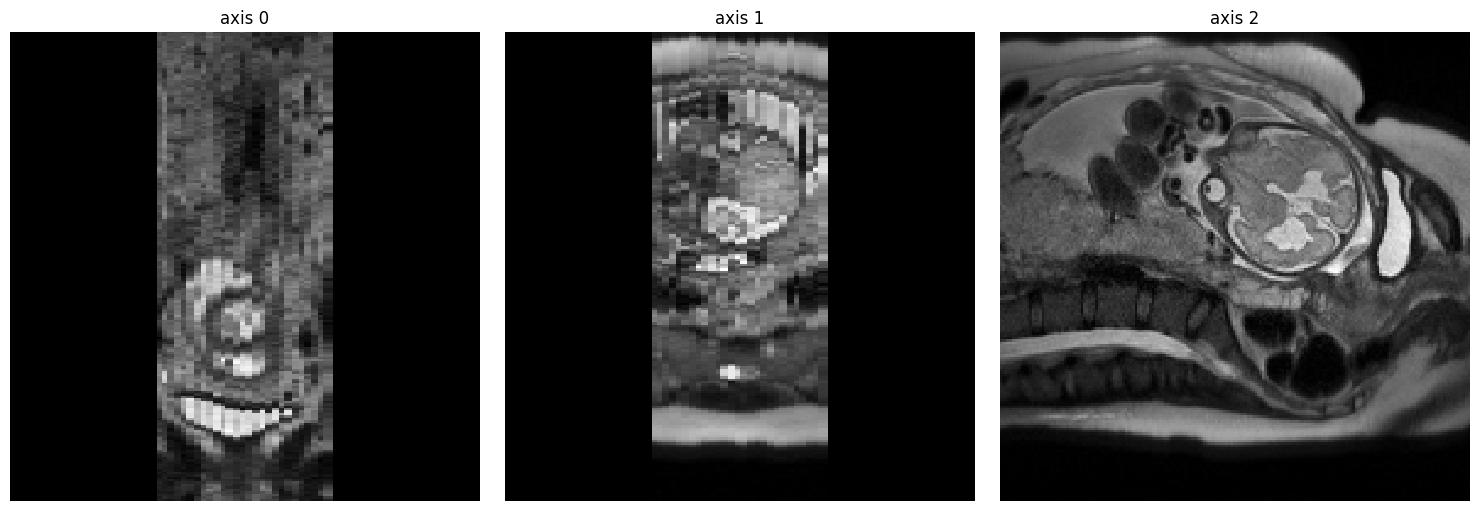

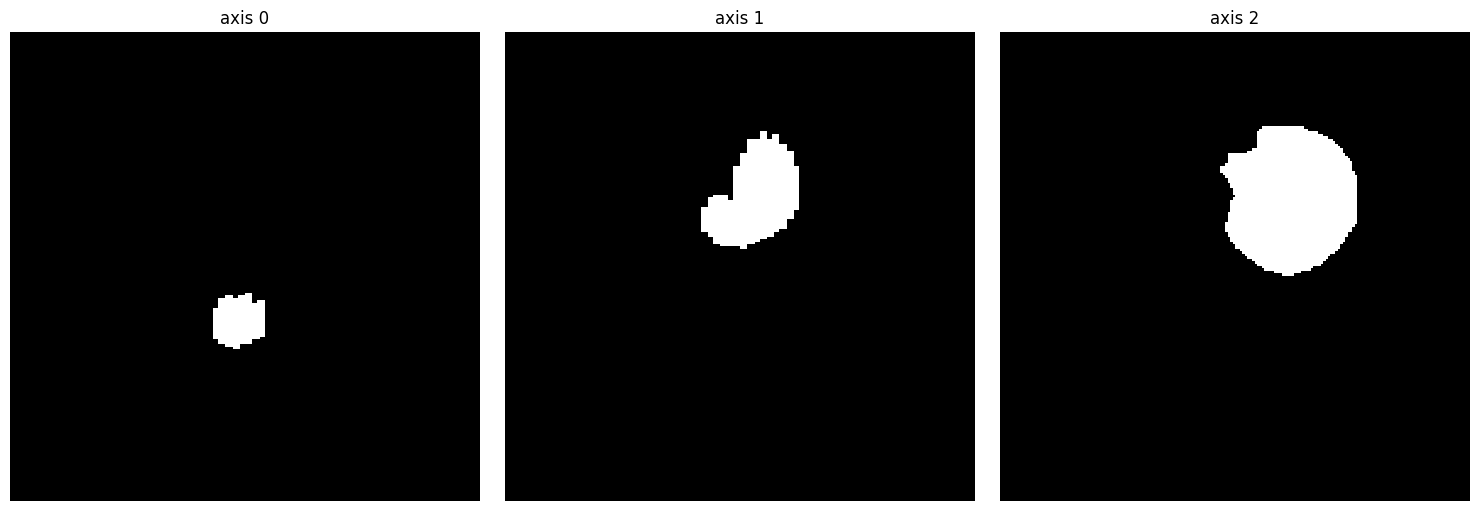

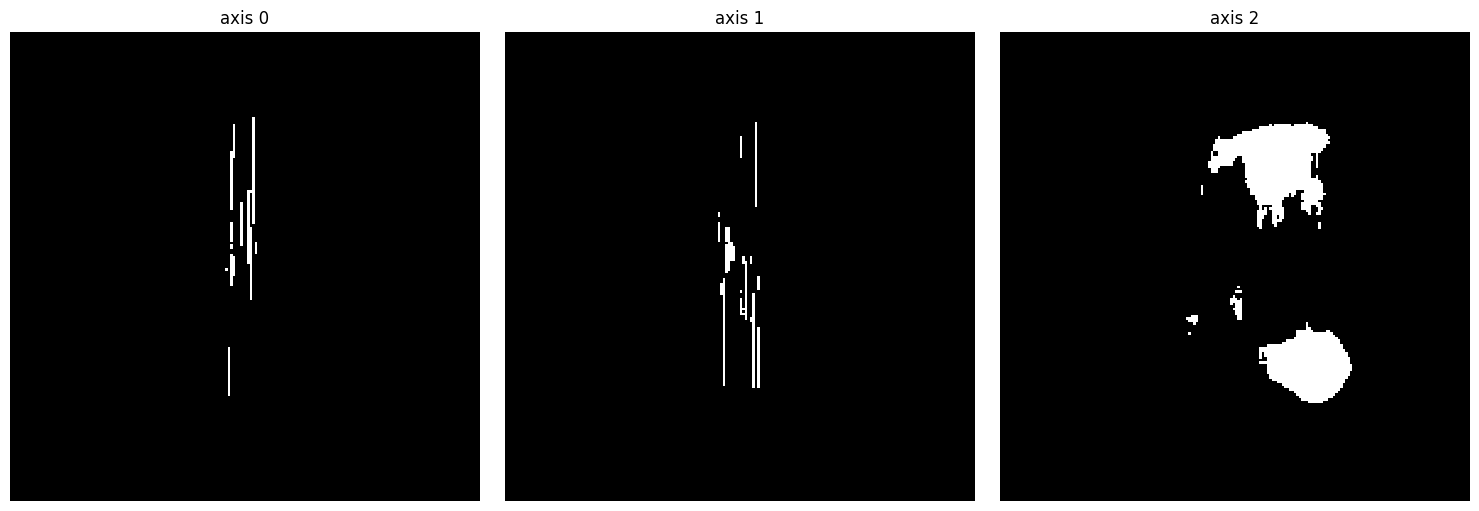

Hard Dice Coefficient: 0.13077447195094255


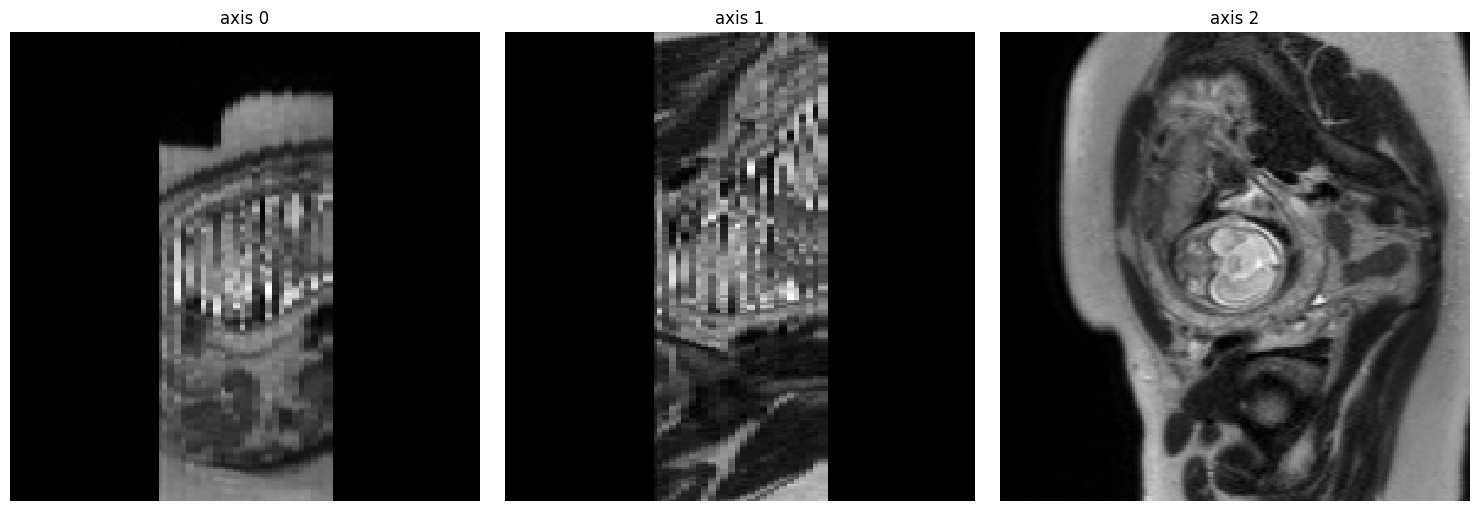

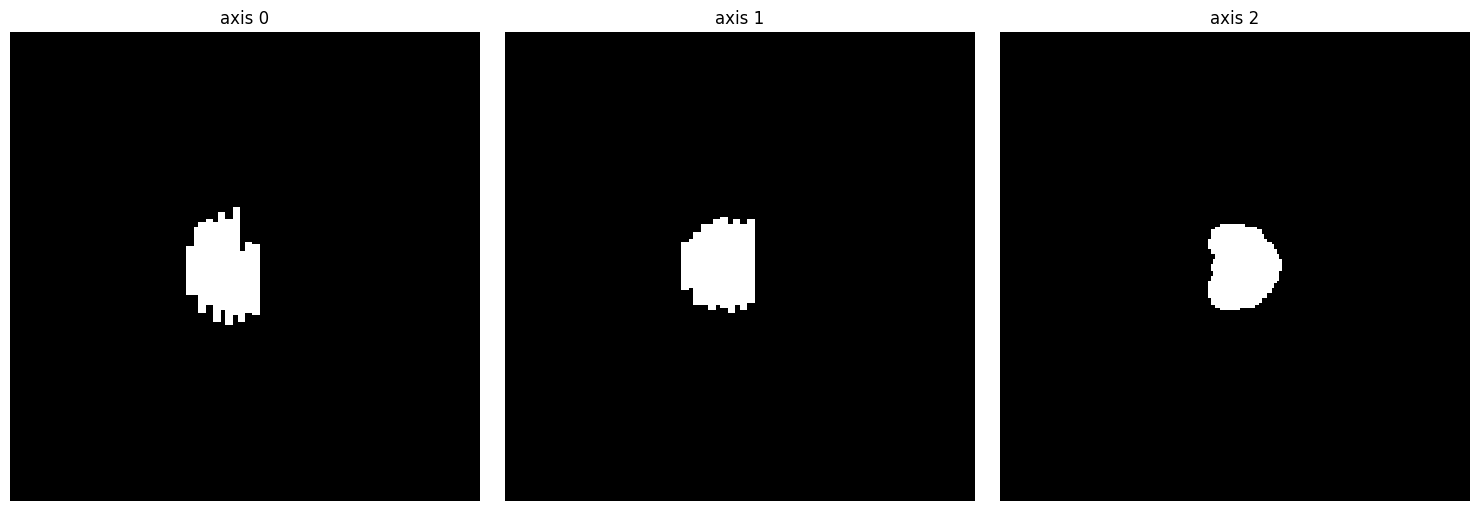

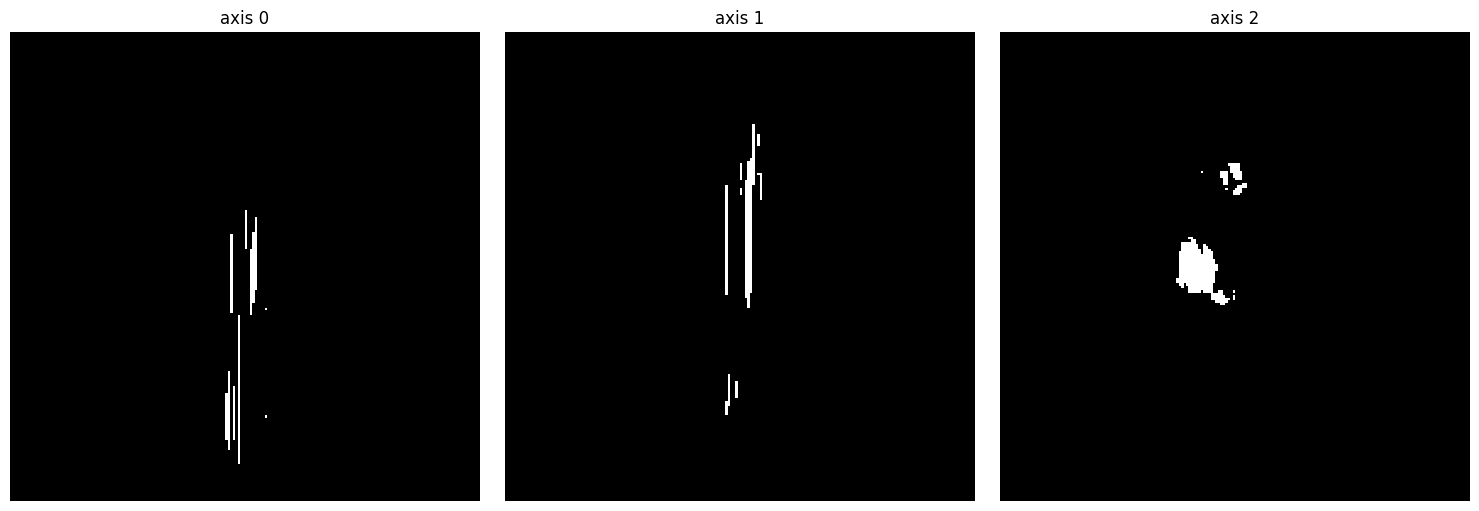

Hard Dice Coefficient: 0.07299338468169637


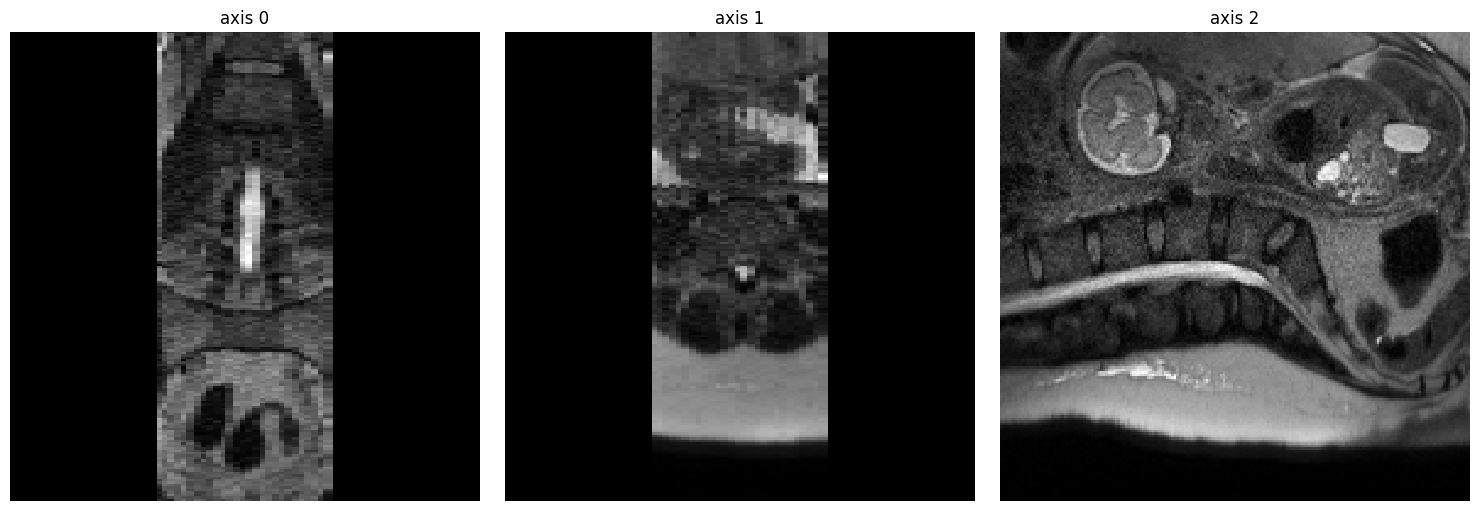

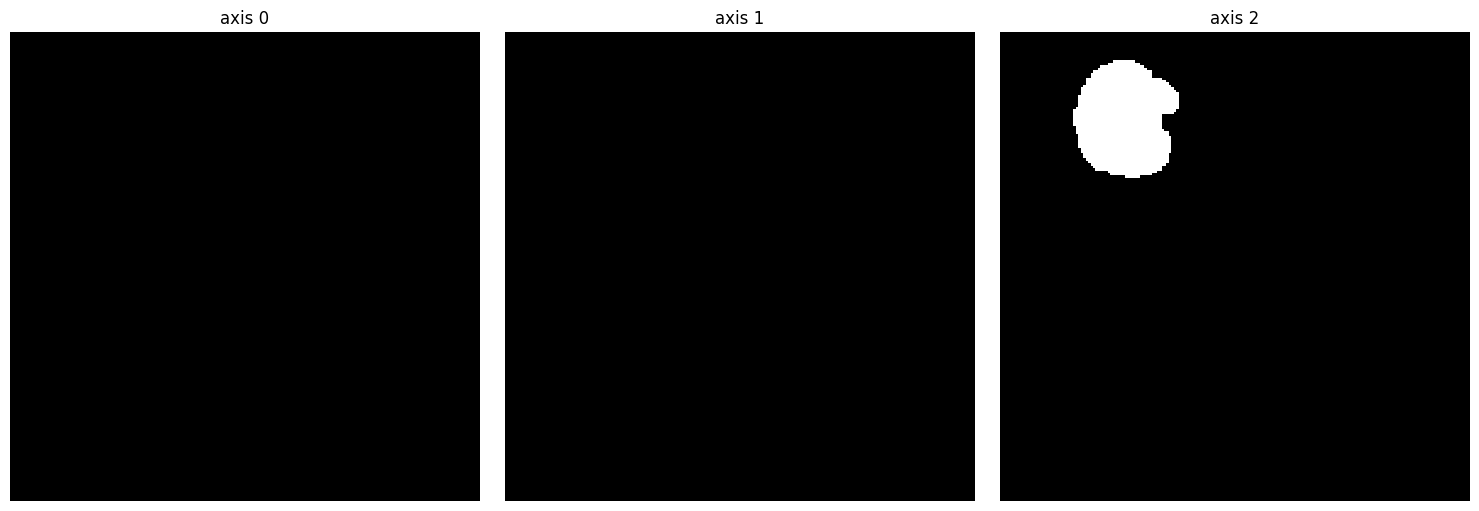

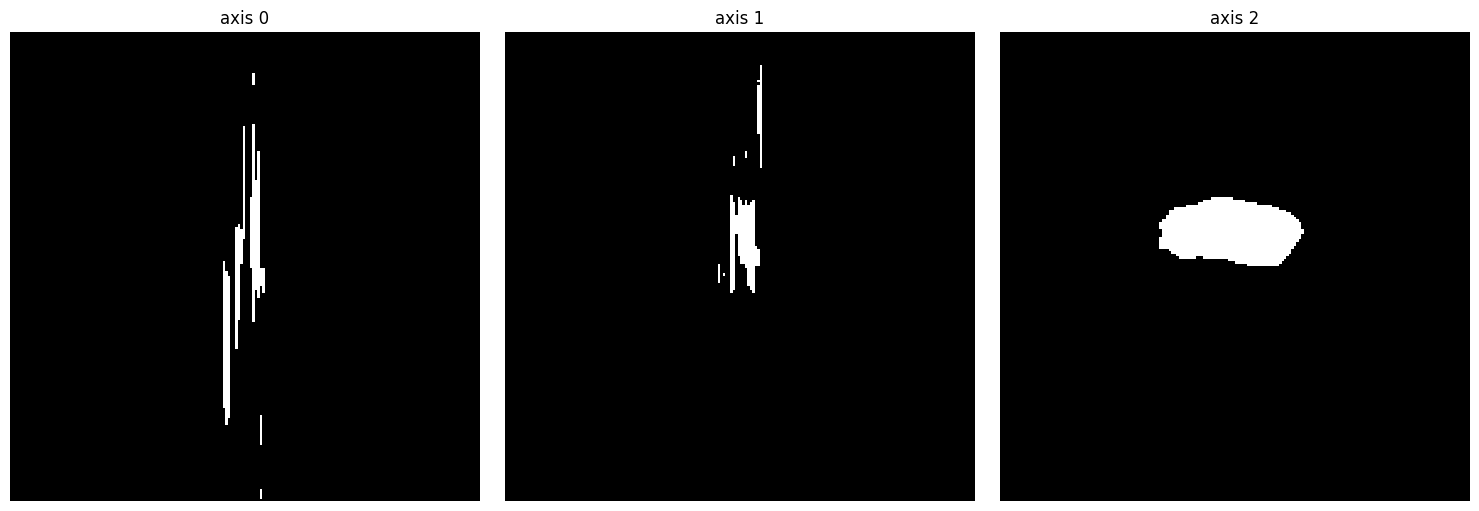

Hard Dice Coefficient: 0.0


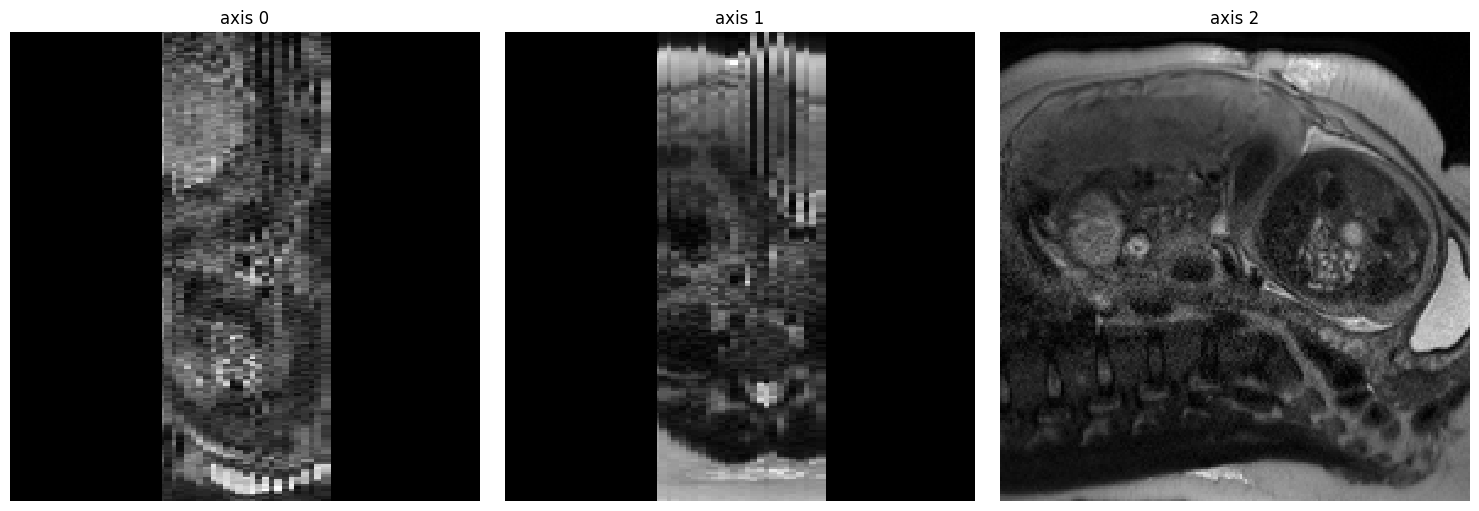

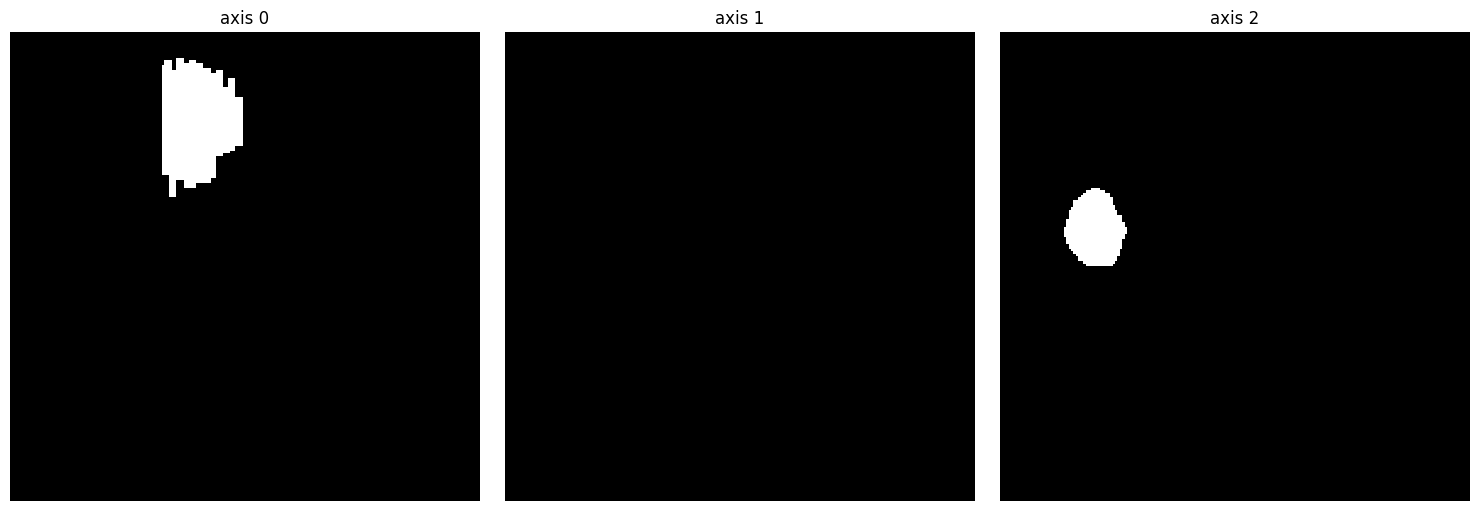

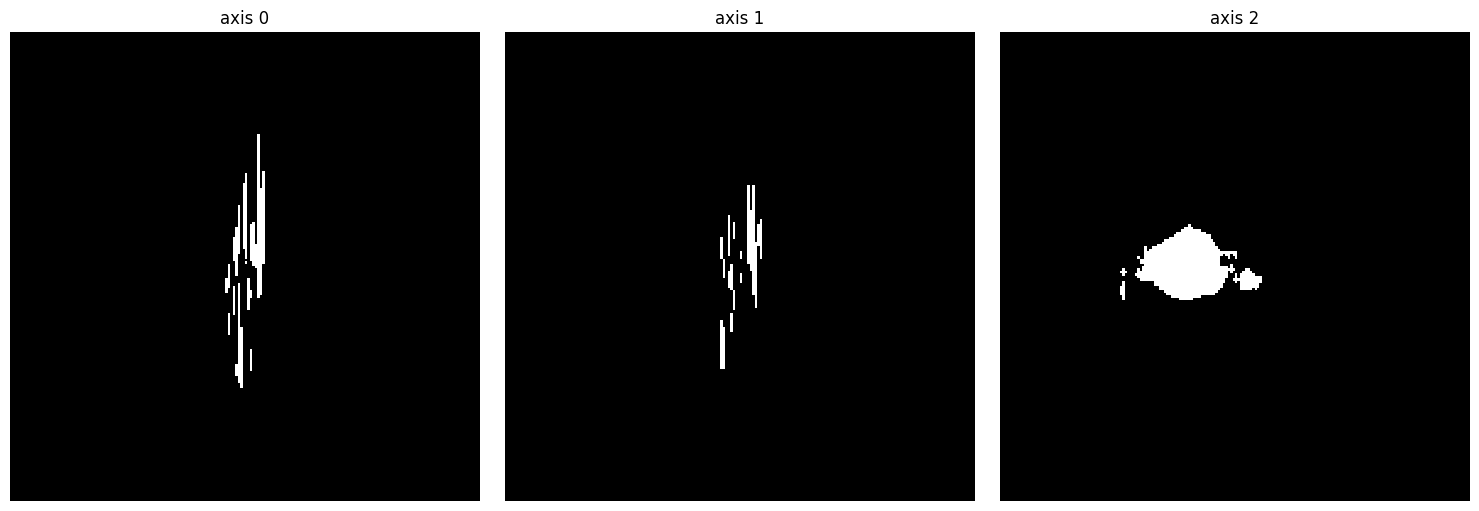

Hard Dice Coefficient: 0.09942683354778337


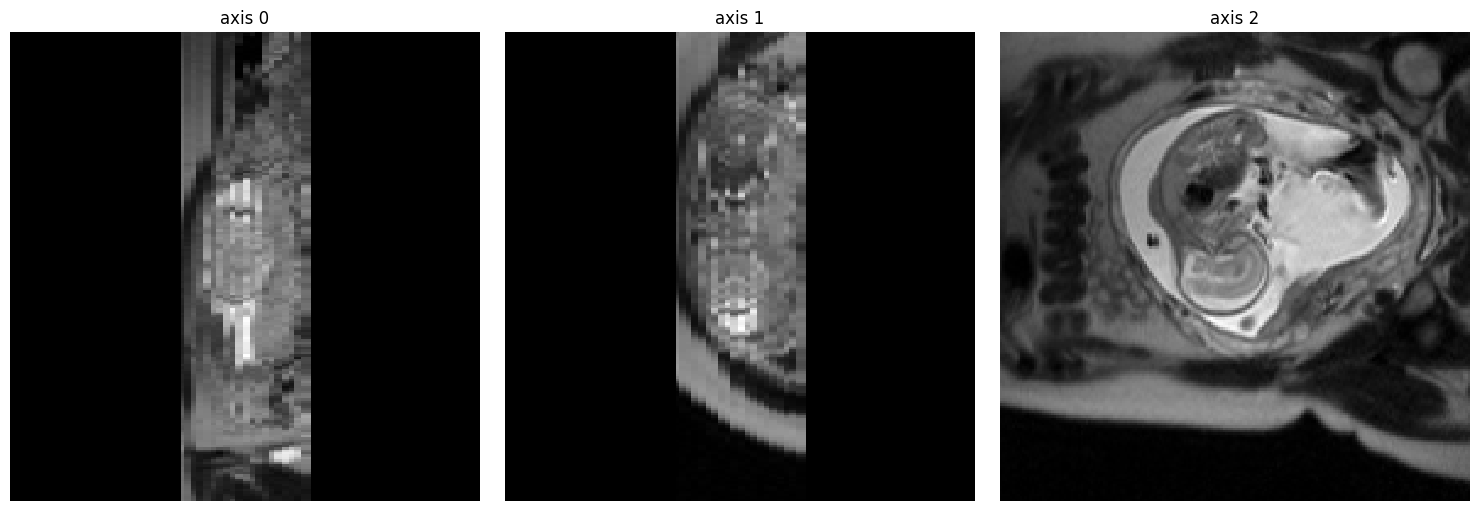

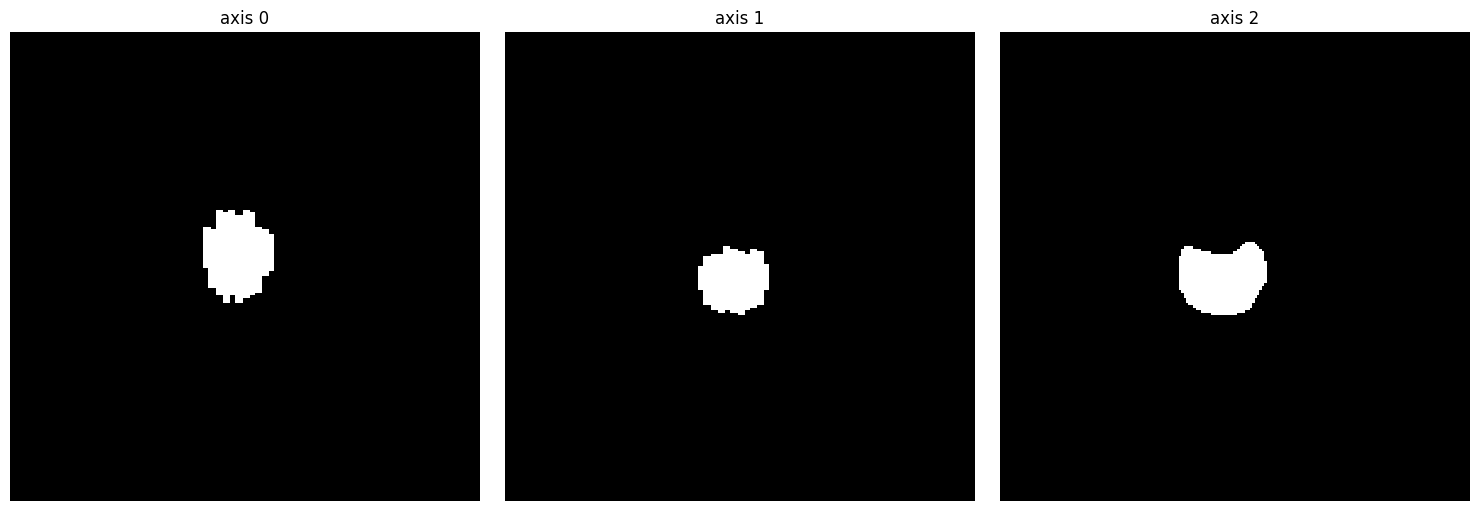

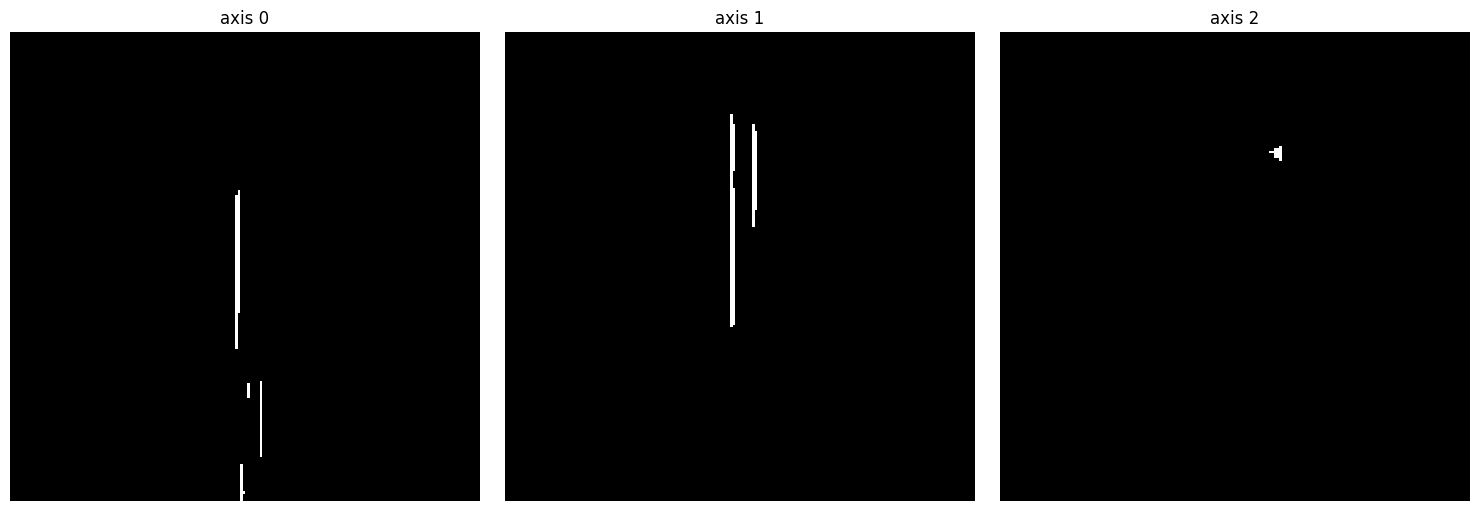

Hard Dice Coefficient: 0.07422621594637


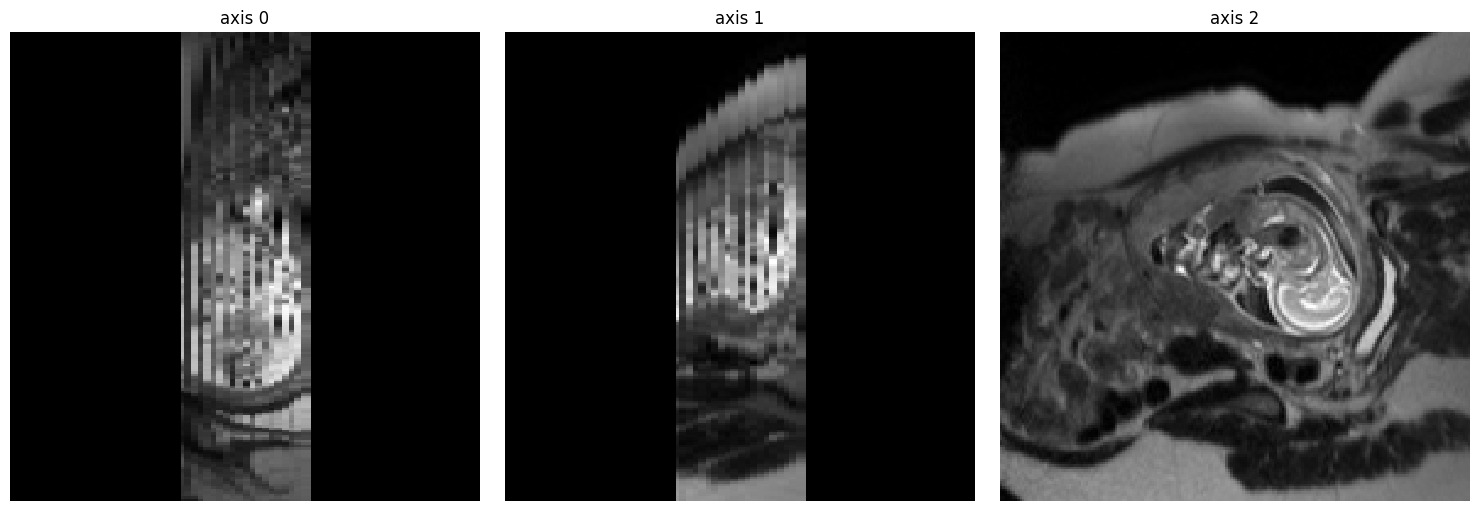

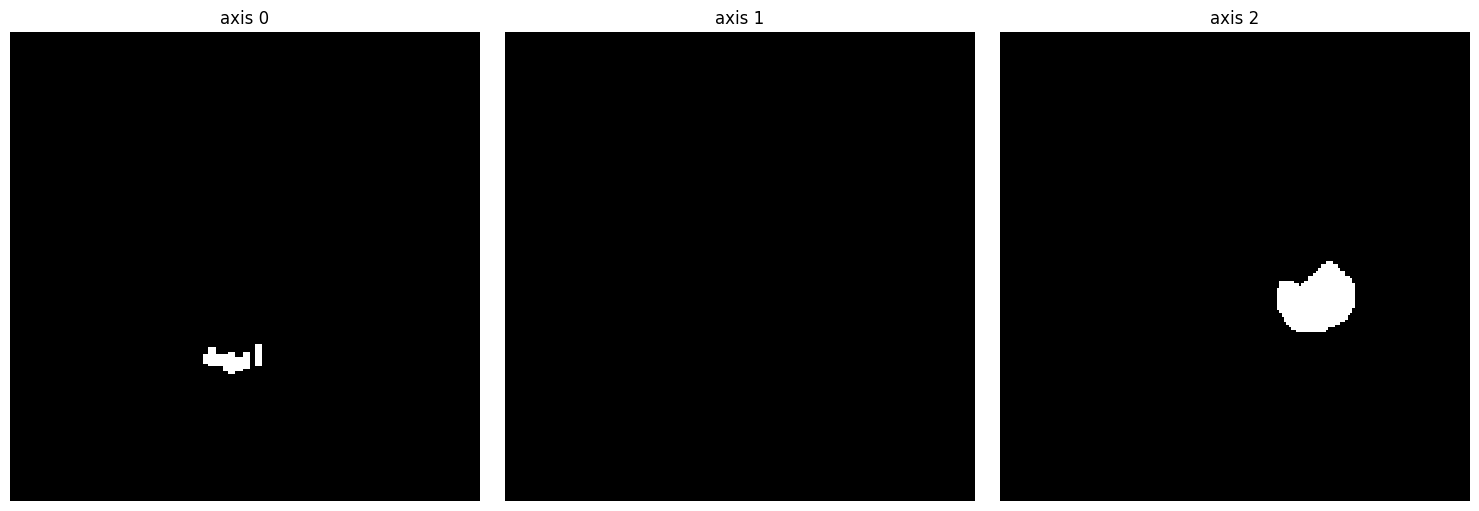

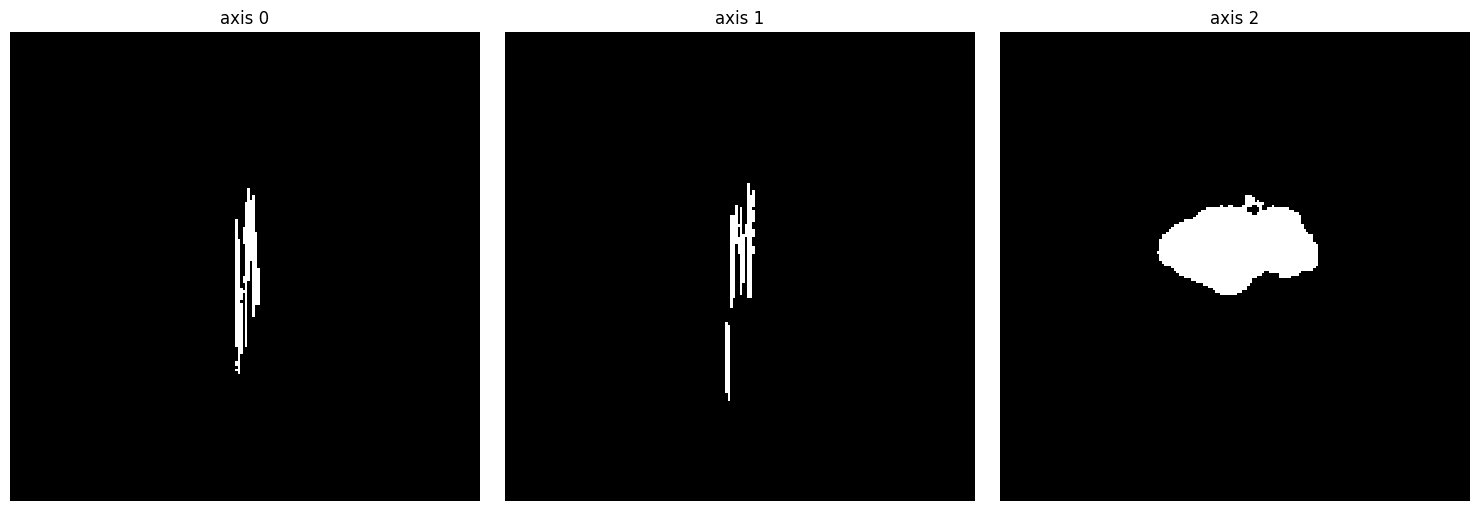

Hard Dice Coefficient: 0.06178535348660631


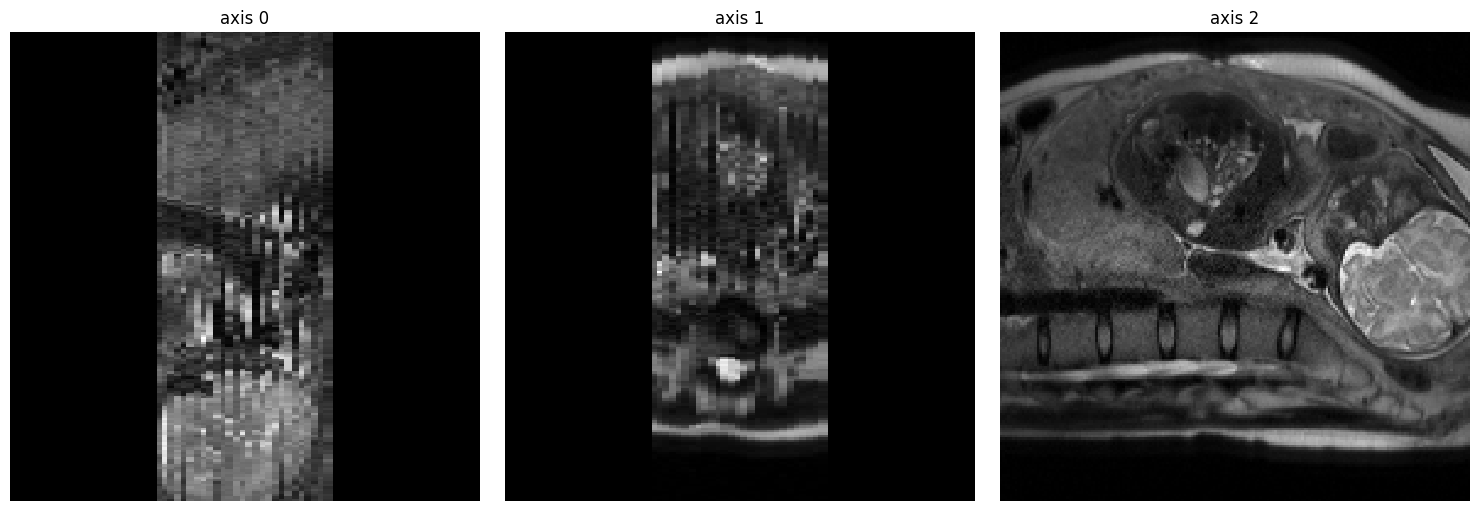

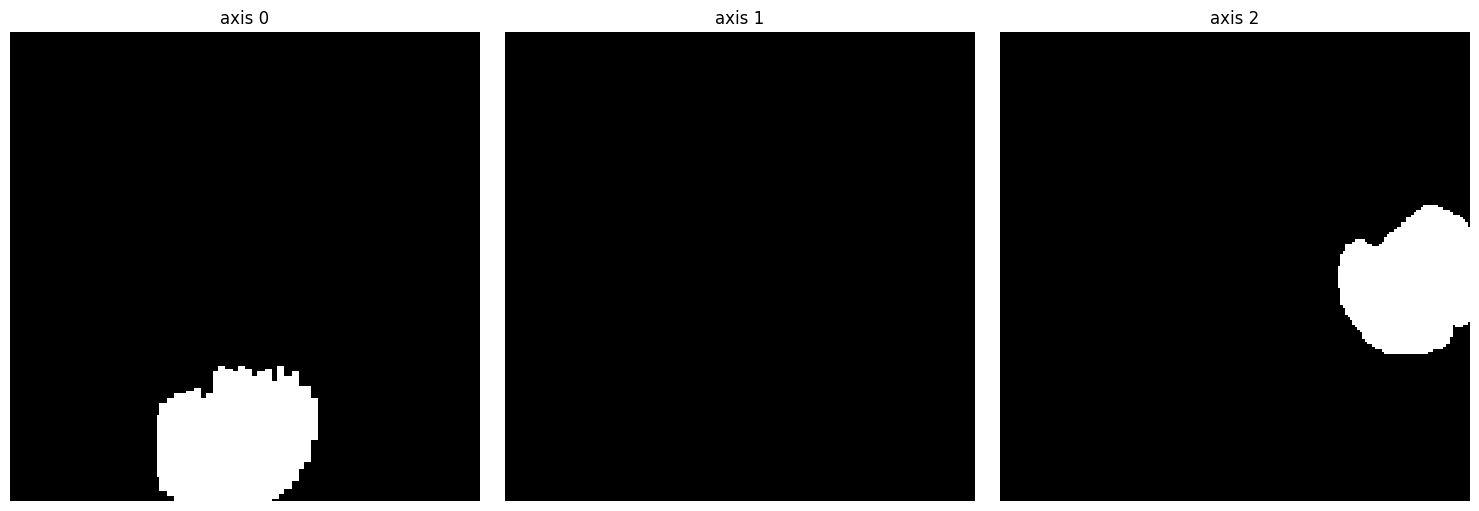

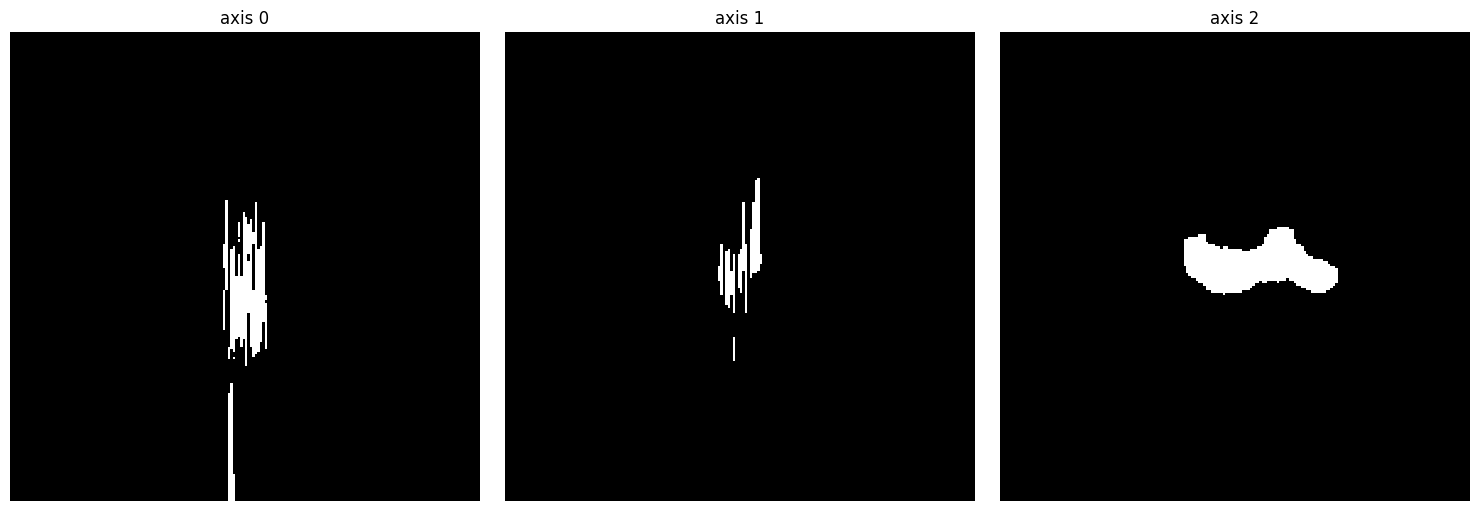

Hard Dice Coefficient: 0.007392646426757316


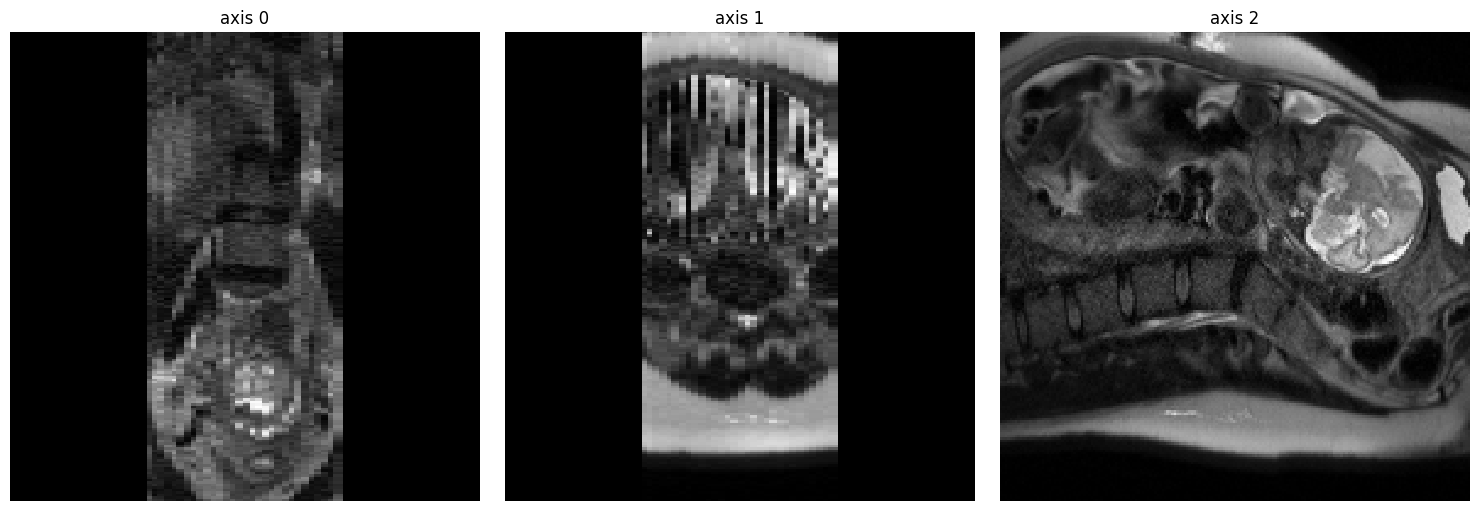

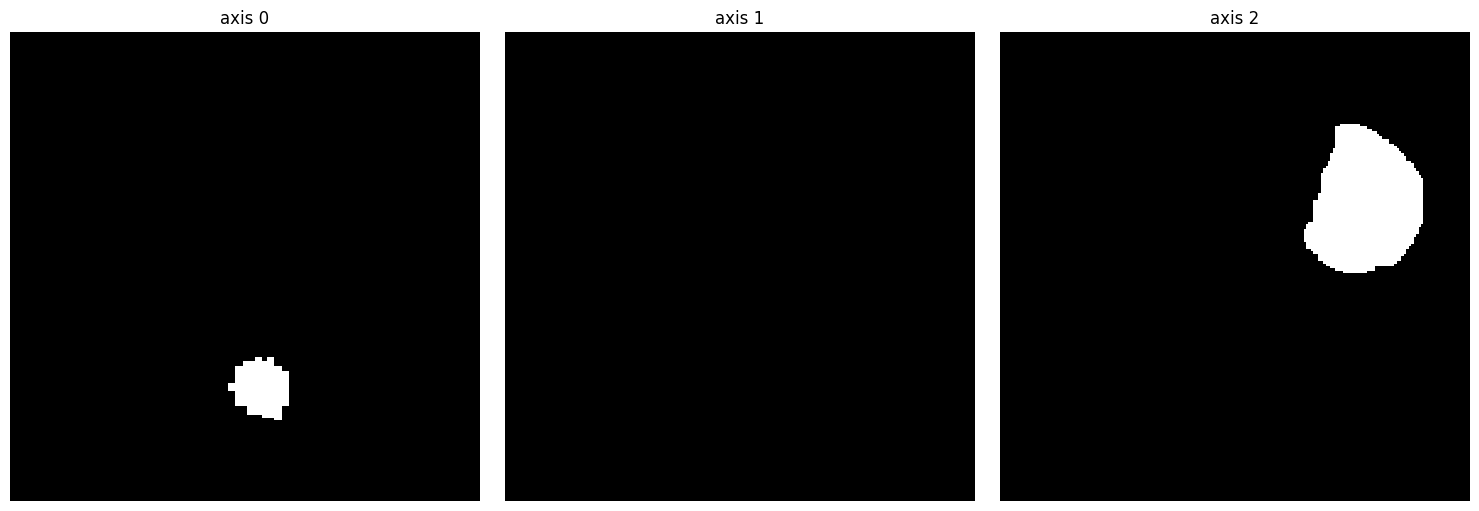

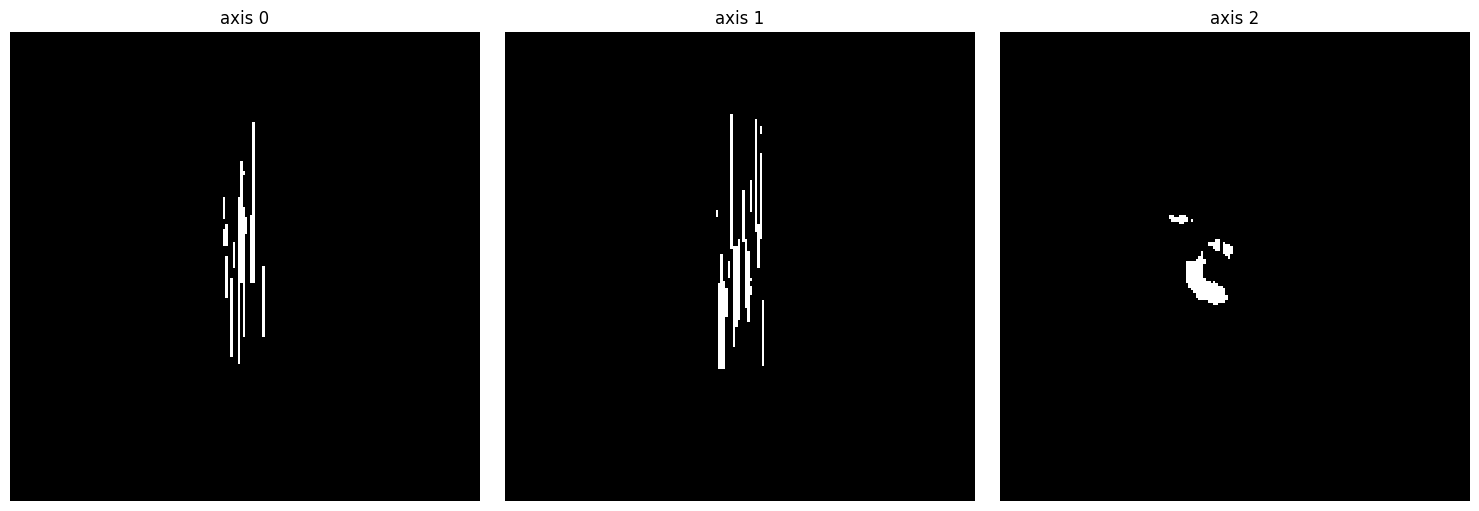

Hard Dice Coefficient: 0.06325428685023919


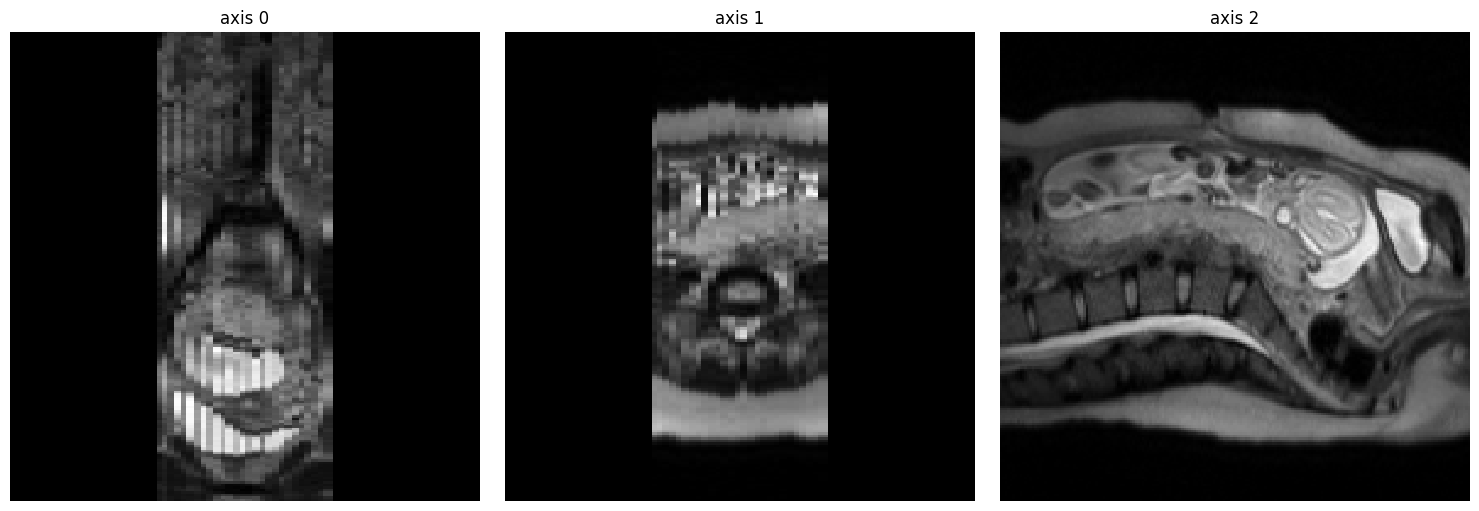

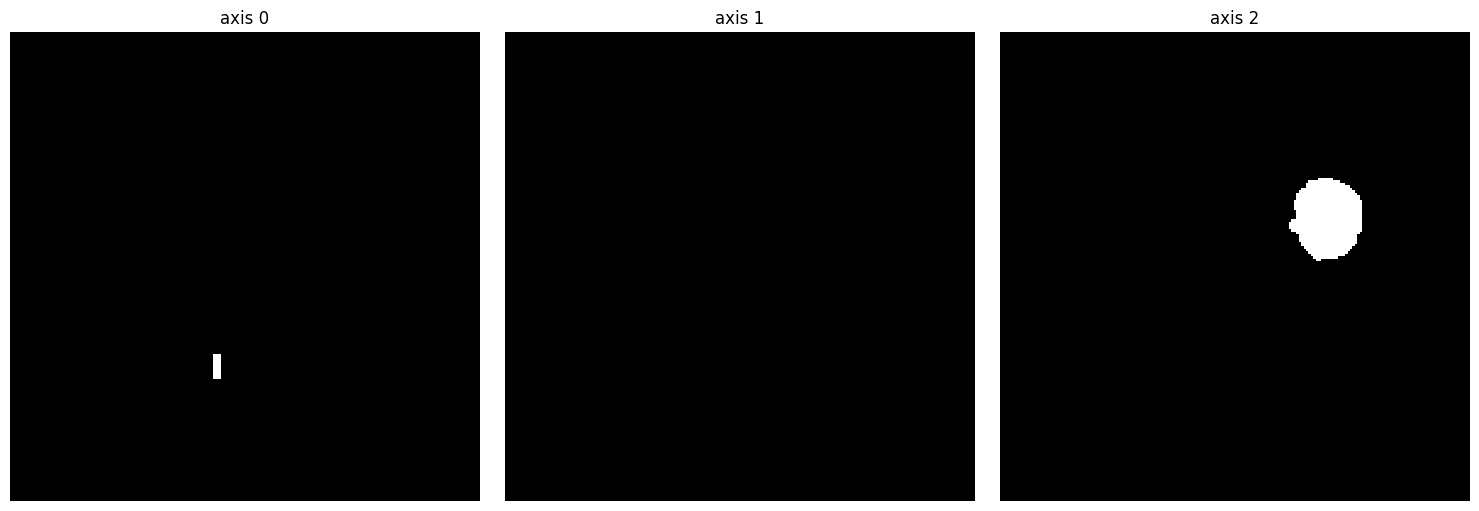

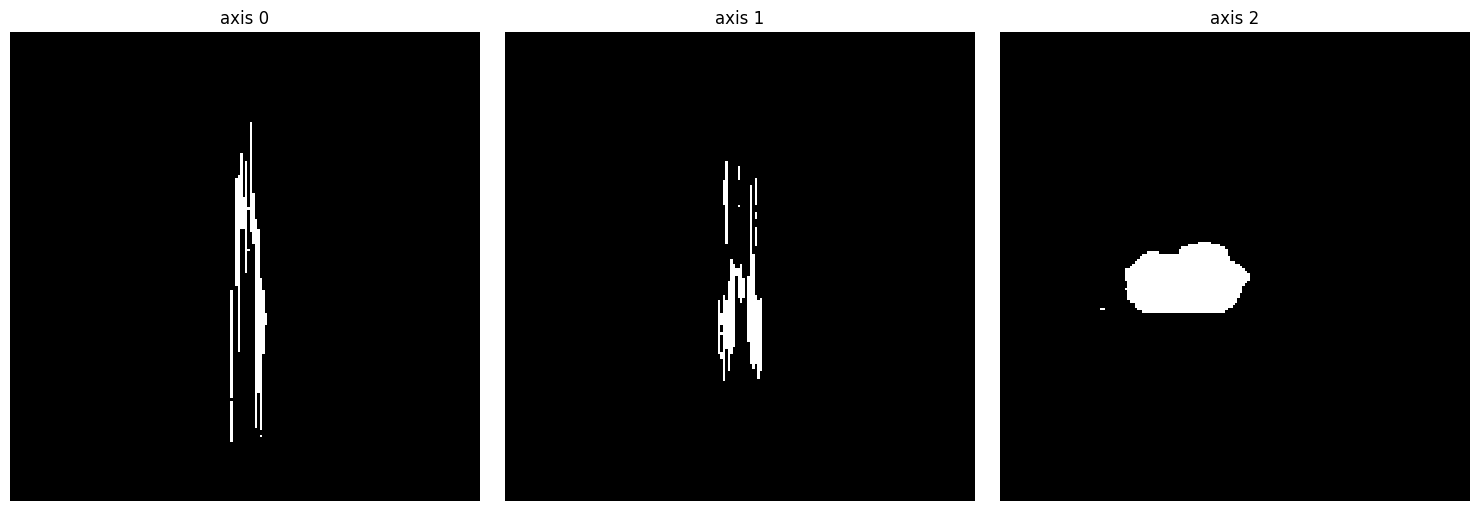

Hard Dice Coefficient: 0.13763949180663196


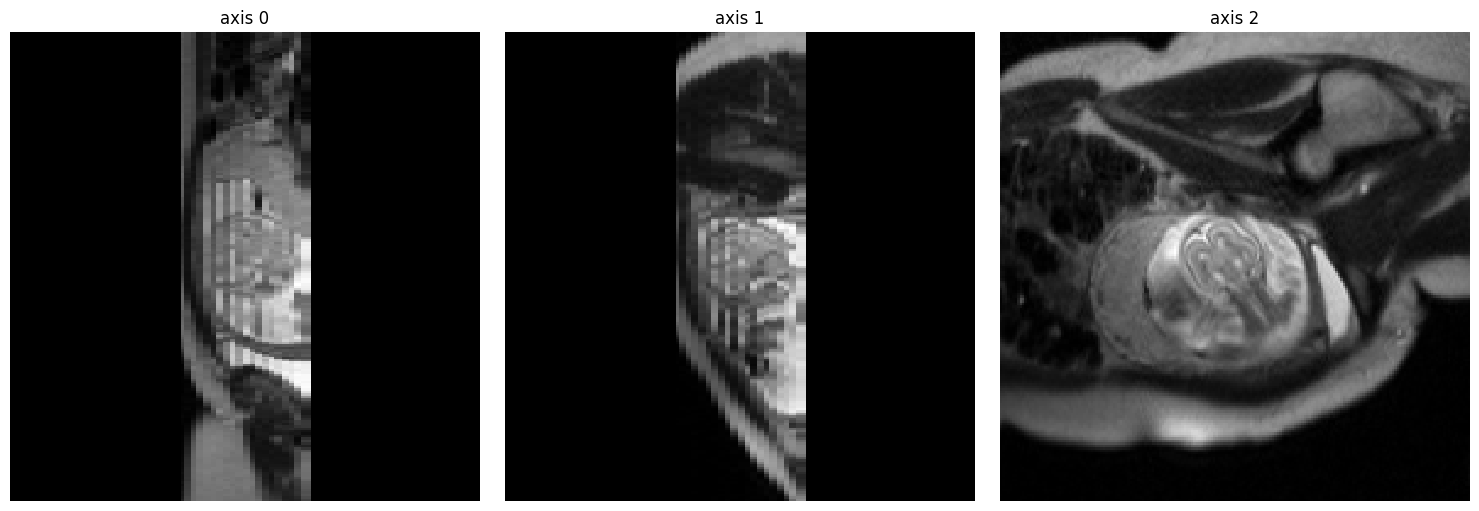

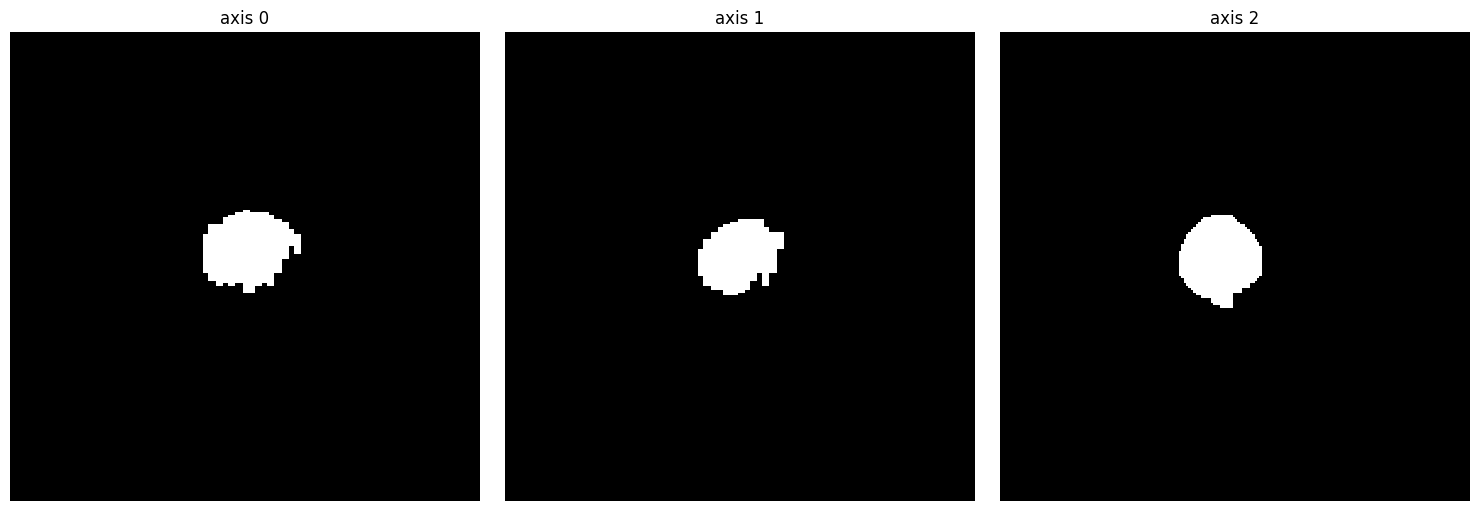

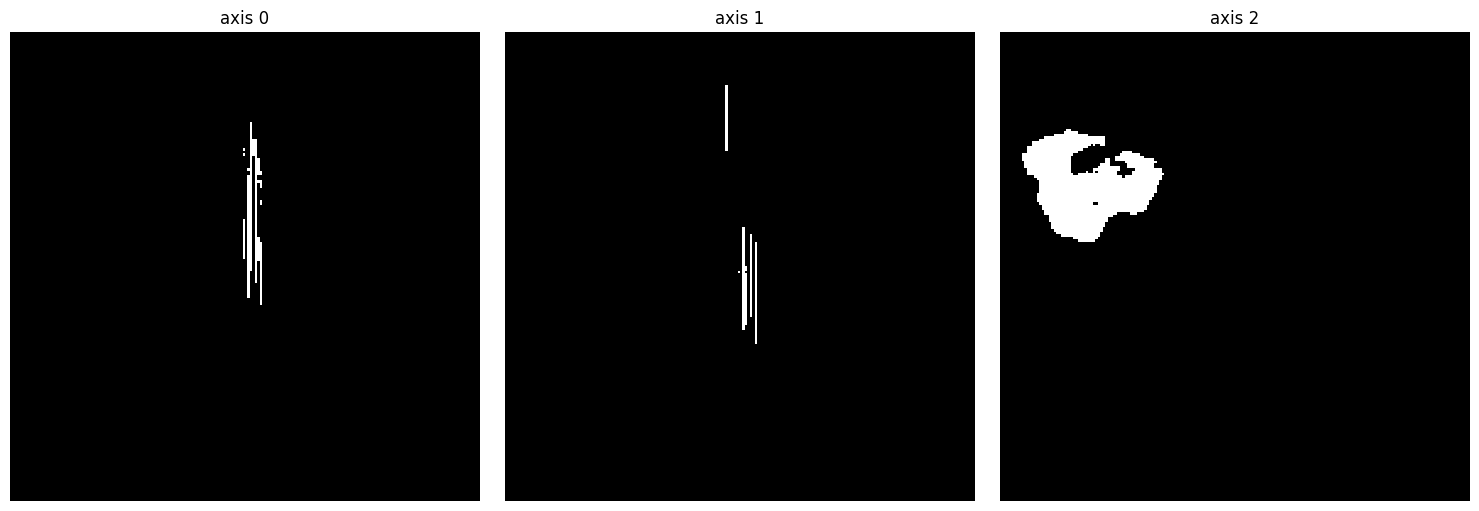

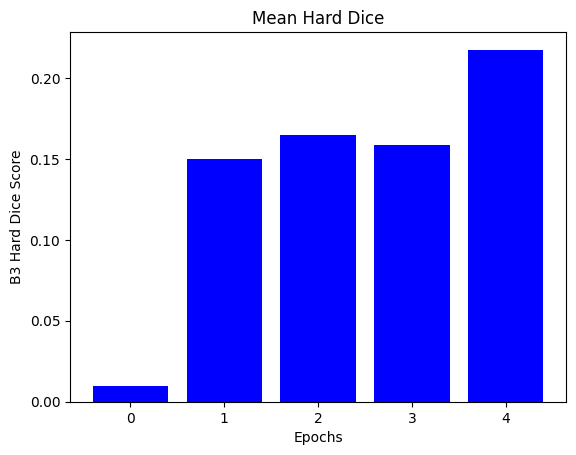

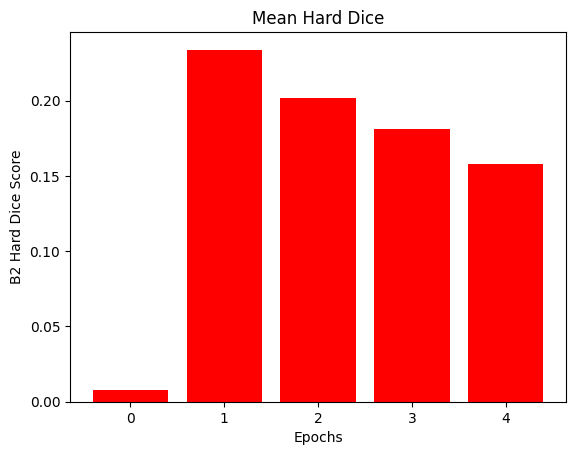

In [11]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf
import numpy as np

import os
import numpy as np
import surfa as sf
from utils import resize
import re

import numpy as np
from sklearn.metrics import f1_score



def extract_slices(inp,stride):
    # print(inp.shape)
    out = tf.transpose(inp[0], perm=(2, 0, 1, 3))
    
    return out[::stride]
    
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (union) 
    
def process_image_2d(im, unet_model):
    a = im.copy()
    sliced_img= extract_slices(a,slice_stride)
    return unet_model.predict(sliced_img, verbose=0)
    
def my_hard_dice(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    dice = dice_coefficient(y_true_flat, y_pred_flat)
    return dice

def soft_dice(a, b):
    dim = len(a.shape) - 2
    space = list(range(1, dim + 1))
    # print("dim",dim,"space",space,"a.dim",a.shape,"b.dim",b.shape)
    top = 2 * tf.reduce_sum(a * b, axis=space)
    bot = tf.reduce_sum(a ** 2, axis=space) + tf.reduce_sum(b ** 2, axis=space)
    
    out = tf.divide(top, bot + 1e-6)
    return -tf.reduce_mean(out)

def my_dice_coefficient(y_true, y_pred, smooth=1e-8):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)
    
def minmax_norm(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)

def find_manual_mask(filename):
    base_filename, _ = os.path.splitext(filename)  # Separate filename and extension
    pattern = re.compile(rf"manual_masks_b\d+_mom_\d+_{re.escape(base_filename)}_segment\.nii\.gz")

    matches = [f for f in os.listdir("mgh_2d") if pattern.match(f)]
    
    if matches:
        return matches[0]
        
tf.get_logger().setLevel('ERROR')

warp_blur_min=np.array([2, 4, 8])
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2





random.seed(3000)

def load_model3D(checkpoint_path, slice_stride = 4, num_dim=3,nb_labels=2,
                                            dimx=192,
                                            dimy=192,
                                            dimz=192,
                                            batch_size=8,
                                            warp_max=2.5,
                                            warp_min=.5,
                                            warp_blur_min=np.array([2, 4, 8]),
                                            warp_blur_max=warp_blur_min*2,
                                            bias_blur_min=np.array([2, 4, 8]),
                                            bias_blur_max=bias_blur_min*2,
                                            initial_lr=1e-4,
                                            lr = 1e-4,
                                            lr_lin = 1e-4,
                                            nb_levels=5,
                                            conv_size=3,
                                            num_epochs=40000,
                                            num_bg_labels=16,
                                            nb_conv_per_level=2):

    
    unet_model = vxm.networks.Unet(inshape=(192,192,1), nb_features=(en, de), 
                                   nb_conv_per_level=nb_conv_per_level,
                                   final_activation_function='softmax')
    input_img = Input(shape=(192,192,192,1))

    # if args.shapes:
    # generated_img, y = labels_to_image_model_with_shapes(input_img)
   
    sliced_img= extract_slices(input_img,slice_stride)
    # y  = extract_slices(y , slice_stride)
    segmentation = unet_model(sliced_img)

    combined_model = Model(inputs=input_img, outputs=segmentation)
    # combined_model.add_loss(soft_dice(y, segmentation))
    
    # combined_model.compile(optimizer=Adam(learning_rate=initial_lr))
    if os.path.exists(checkpoint_path):
        combined_model.load_weights(checkpoint_path)
        print("Loaded weights from the checkpoint and continued training.")
    else:
        # print(checkpoint_path)
        print("Checkpoint file not found.")
    
    # input_img = Input(shape=(dimx, dimy, dimz, 1))
    
    # unet_model = vxm.networks.Unet(inshape=(dimx, dimy, dimz, 1), nb_features=(en, de), 
    #                                nb_conv_per_level=nb_conv_per_level,
    #                                final_activation_function='softmax')

    # segmentation = unet_model(input_img)
    # combined_model = Model(inputs=input_img, outputs=segmentation)

    # if os.path.exists(checkpoint_path):
    #     combined_model.load_weights(checkpoint_path)
    #     print("Loaded weights from the checkpoint and continued training.")
    # else:
    #     # print(checkpoint_path)
    #     print("Checkpoint file not found.")
    unet_model = combined_model.layers[-1]

    return unet_model


num_row = 3
per_row = 10

    
def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.sum(np.logical_and(ground_truth, predicted))
    union = np.sum(np.logical_or(ground_truth, predicted))

    dice_coefficient = (2.0 * intersection) / (union + intersection)
    return dice_coefficient

def print_row_dice_coefficients(i, row_dice_coefficients):
    formatted_dice = [f"   {dice:.4f}" for j, dice in enumerate(row_dice_coefficients)]
    num_spaces = num_row-1
    padding_left = 0
    padding_right = 0

    formatted_output = f"{' ' * padding_left}{'       '.join(formatted_dice)}{' ' * padding_right}"
    print(f' {formatted_output}')
    

# log_dir='logs_feta'
# initial_epoch=5870

import os, shutil, glob


models_dir='models_2d_synth_stride_4_shapes_feta_192'
# models_dir = 'models_2d_shapes_feta_192'
slice_stride = 4
# latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
# match = re.search(r'weights_epoch_(\d+)\.h5', latest_weight)
# latest_epoch = int(match.group(1))

# en=[16,16, 32,32, 64,64,128,128, 192,192]
# de=[192,192, 128,128,64,64,32,32,16,16,2]

en = [16, 16, 32 ,32 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 32 ,32 ,16 ,16 ,2]

nb_features = '_'.join(map(str, en))
dim_=192


# models_dir='models_feta_mgh_body_params_dim_256_16_16_32_32_64_64_128_128_256_256_wm_0.2_shift_30'
# checkpoint_path=models_dir+latest_weight#'/weights_epoch_'+str(initial_epoch)+'.h5'
# print(checkpoint_path)
# combined_model = load_model3D(checkpoint_path,num_dim=3, dimx=dim_,
#                                                        dimy=dim_,
#                                                        dimz=dim_)

# dataset="samples"
def calculate_hard_dice_2d(image, model, mask_filename):
    # mask = sf.load_volume(mask_filename).reshape((dim_, dim_, dim_))

    # print("image shape",image.data.shape)
    prediction_one_hot = process_image_2d(image.data[None,...,None], model)
    predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
    # prediction = np.squeeze(predictions_argmax, axis=0)
    mask.data[mask.data != 0] = 1
        # out = tf.transpose(inp[0], perm=(2, 0, 1, 3))

    prediction = tf.transpose(predictions_argmax, perm=(1, 2, 0))
    prediction = sf.Volume(prediction).reshape(mask.data.shape)
    # print("predictions_argmax",prediction.shape)

    return my_hard_dice(prediction.data.flatten(),mask.data.flatten())

last_models_hard_dice_scores = []
n = 500
# for i in range(latest_epoch, latest_epoch - n, -10):
latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)

match = re.search(r'(\d+)', latest_weight.split("/")[1])
initial_epoch = int(match.group())
# print(initial_epoch)
# checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'
# combined_model = load_model3D(checkpoint_path,num_dim=3, dimx=dim_,
#                                                        dimy=dim_,
#                                                        dimz=dim_)
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'
print(checkpoint_path)
combined_model = load_model3D(checkpoint_path, slice_stride, num_dim=3, dimx=dim_,
                                                       dimy=dim_,
                                                       dimz=dim_)
# combined_model.summary()

validation_folder_path="validation"
subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
def visualize(combined_model,image,mask):
    crop_img = image.resize([1.5, 1.5, 1.5]).reshape((dim_, dim_, dim_,1))    
    crop_data = minmax_norm(crop_img.data)
    
    prediction_one_hot = process_image_2d(crop_data[None,...,None], combined_model)
    predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
    prediction = tf.transpose(predictions_argmax, perm=(1, 2, 0))
    prediction = sf.Volume(prediction).reshape(mask.data.shape)
    
    # prediction = sf.Volume(prediction)#.reshape(mask.data.shape)#.resample_like(mask)
    # mask.data[mask.data != 0] = 1
    hard_dice_score = my_hard_dice(mask.data, prediction.data)
    
    print(f"Hard Dice Coefficient: {hard_dice_score}")
    
    ne.plot.volume3D(crop_img);
    ne.plot.volume3D(mask);
    ne.plot.volume3D(prediction);


new_voxsize = [1.5,1.5,1.5]

b2_hard_dice_scores=[]
b3_hard_dice_scores=[]
# last_soft_dice_scores=[]
latest_images=[]
latest_masks=[]
step_size=10000
for w in range(0, initial_epoch+1, step_size):
    checkpoint_path=models_dir+'/weights_epoch_'+str(w)+'.h5'
    combined_model = load_model3D(checkpoint_path, slice_stride, num_dim=3, dimx=dim_,
                                                           dimy=dim_,
                                                           dimz=dim_)

    b2_10_hard_dice_scores = []
    b3_10_hard_dice_scores = []
    # last_10_soft_dice_scores =[]
    for folder in subfolders:
        folder_path = os.path.join(validation_folder_path, folder)
        filename = os.path.join(folder_path,"image.nii.gz")
        mask_filename = os.path.join(folder_path,"manual.nii.gz")
        image = sf.load_volume(filename)
        orig_voxsize = image.geom.voxsize
        crop_img = image.resize([orig_voxsize[0],orig_voxsize[1],1.5], method="nearest")
        crop_img = crop_img.resize(new_voxsize, method="linear").reshape([dim_, dim_, dim_])
        crop_data = minmax_norm(crop_img.data)
    
        mask = sf.load_volume(mask_filename).resize([orig_voxsize[0],orig_voxsize[1],1
                                                    ], method="nearest")
        mask = mask.resize(new_voxsize).reshape([dim_, dim_, dim_, 1])
        mask.data[mask.data != 0] = 1
        hard_dice_score = calculate_hard_dice_2d(crop_img, combined_model, mask)

        # prediction_one_hot = process_image(crop_data, combined_model)
        # print(np.unique(mask.data))
        # a = to_categorical(mask.data, num_classes=2)[None,...]
        # b=prediction_one_hot
        # soft_dice_score = soft_dice(a, b)
        # hard_dice_score = my_hard_dice(mask.data, prediction.data)
                
        # last_10_soft_dice_scores.append(soft_dice_score)
        mom = int(folder.split("_")[1])
        # print(folder)
        if mom < 100:
            b2_10_hard_dice_scores.append(hard_dice_score)
        else:
            b3_10_hard_dice_scores.append(hard_dice_score)
        if abs(w-initial_epoch)<step_size:
            print(w)
            latest_images.append(crop_img)
            latest_masks.append(mask)
    b2_hard_dice_scores.append(np.mean(b2_10_hard_dice_scores))
    b3_hard_dice_scores.append(np.mean(b3_10_hard_dice_scores))
    # last_soft_dice_scores.append(np.mean(last_10_soft_dice_scores))

        # visualize(image,mask)
for i in range(len(latest_images)):
    visualize(combined_model, latest_images[i],latest_masks[i])
# last_hard_dice_scores.reverse()
plt.bar(range(len(b3_hard_dice_scores)), b3_hard_dice_scores, color='blue')
plt.xlabel('Epochs')
plt.ylabel('B3 Hard Dice Score')
plt.title('Mean Hard Dice')

plt.show()

plt.bar(range(len(b2_hard_dice_scores)), b2_hard_dice_scores, color='red')
plt.xlabel('Epochs')
plt.ylabel('B2 Hard Dice Score')
plt.title('Mean Hard Dice')

plt.show()

    # files = os.listdir(folder_path)
    # for f in files:
        # print(f"Files in the folder: {f}")
        
# for j in range(10):
#     filename = f'feta_shapes_{j}.nii.gz'
#     mask_filename = f'feta_mask_shapes{j}.nii.gz'

#     image = sf.load_volume(os.path.join(dataset, filename))
#     hard_dice_score = calculate_hard_dice(image, combined_model, mask_filename)
#     last_10_hard_dice_scores.append(hard_dice_score)
# last_models_hard_dice_scores.append(np.mean(last_10_hard_dice_scores))
    # filename="feta_shapes_0.nii.gz"
    # manual_mask='feta_mask_shapes0.nii.gz'


    

# image = sf.load_volume(os.path.join(dataset, filename))#.resize()
# print(image.shape,image.geom.voxsize)
# # dim_ = 192

# crop_img = image.resize([1, 1, 1]).reshape((dim_, dim_, dim_,1))
# # crop_img.save("output/crop_img.mgz")

# crop_data = minmax_norm(crop_img.data)

# prediction_one_hot = process_image(crop_data, combined_model)
# predictions_argmax = np.argmax(prediction_one_hot, axis=-1)
# prediction = np.squeeze(predictions_argmax, axis=0)

########### visualize ########

# mask = sf.load_volume(os.path.join(dataset, manual_mask)).reshape((dim_, dim_, dim_))
# prediction = sf.Volume(prediction)#.reshape(mask.data.shape)#.resample_like(mask)

# output_file_path = os.path.join('output', 'prediction.nii.gz')
# save_prediction(crop_img, prediction, output_file_path)

# a = to_categorical(mask.data, num_classes=2)[None,...]
# b=prediction_one_hot
# dice_score = soft_dice(a, b)
# hard_dice_score = my_hard_dice(mask.data, prediction.data)

# Average the last 10 hard dice scores
# average_hard_dice = np.mean(last_10_hard_dice_scores)

# Plot the results for the last 20 models
# k = len(last_models_hard_dice_scores)
# plt.plot(range(initial_epoch, initial_epoch - 10*k, -10), last_models_hard_dice_scores[-k:][::-1], marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Hard Dice Score')
# # plt.title(f'Last 20 Models Hard Dice Scores (Average: {last_models_hard_dice_scores:.4f})')
# plt.show()

In [19]:
latest_weight = max(glob.glob(os.path.join(models_dir, 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
match = re.search(r'weights_epoch_(\d+)\.h5', latest_weight)
latest_epoch = int(match.group(1))

In [10]:
print(np.max(mask.data))

1.0000001


In [11]:
image.geom.voxsize

array([1.5625, 1.5625, 4.    ])